In [30]:
#IMPORT LIBRARIES
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import sys
import os
import pyshred
# import seaborn as sns
# import sys
# from __future__ import print_function
# from IPython.display import clear_output as clc
# from tqdm import tqdm

# import cmcrameri.cm as cmc

# plt.style.use('default')

In [61]:
# DOMAIN DISCRETIZATION
def u_sol(t,x,n,Kn = 1,l = 1,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)
l = 1
c = 1
T = 4
N_t = 200
N_X = 400
t= np.linspace(0,T,N_t)
x = np.linspace(0,l,N_X)

def data_generate(n,t,x,l=1,c=1):
    data = np.zeros((len(t),len(x)))
    for i in range(len(t)):
        data[i,:] = u_sol(t[i],x,n =n)
    return data
data = data_generate(n=1,t=t,x=x)

In [62]:
lags = 16
x1 = 0.80
x2 = 0.05
x3 = 0.5
sensors = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]

def trajectory_gen(data_list,lags,sensors):
    t_dim = data_list[0].shape[0]
    x_dim = data_list[0].shape[1]
    trajectories = np.zeros((t_dim-lags,len(sensors),lags))
    full_states = np.zeros((t_dim-lags,x_dim))
    
    for n, data_temp in enumerate(data_list):       
        for i in range(t_dim-lags):
            for j in range(len(sensors)):
                trajectories[i,j,:] = data_temp[i:i+lags,sensors[j]]
            full_states[i,:] = data_temp[i+lags,:]

        if n < 1:
            X = trajectories.copy()
            y = full_states.copy()
        
        else:
            X = np.vstack((X,trajectories))
            y = np.vstack((y,full_states))
    return X, y

data_list = []
for n in range(1,20):
    if n != 5:
        data_list.append(data_generate(n=n,t=t,x=x))




X_data, full_states = trajectory_gen(data_list,lags,sensors)
data_save = {
    'X':X_data,
    'y':full_states    
}

np.save('Wave_data/data_1.npy',data_save)

# # print(data[0:lags,sensors[0]])
# fig, ax = plt.subplots(1,2,figsize = (8,4))
# for j in range(len(sensors)):
#     ax[0].plot(data_list[0][:,sensors[j]])
#     ax[0].plot(X_data[:,j, 9],markersize = 10)
#     break


# ax[0].set_title('Sensor data and last input trajectory')
# ax[1].contourf(full_states)
# # ax[1].set_title('Target state at next time step')
# # ax[1].legend()
# plt.show()

# fig,ax = plt.subplots(figsize = (8,4))
# ax.contourf(x,t[lags:],full_states,100,cmap = 'jet')

In [63]:
import torch

class TimeSeriesDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """
    
    def __init__(self, X, Y):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
    

In [64]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load('Wave_data/data_1.npy',allow_pickle=True).item()

data['X'] = torch.tensor(data['X'],dtype = torch.float32,device = device)
data['y'] = torch.tensor(data['y'],dtype = torch.float32,device = device)

generator = torch.Generator().manual_seed(42)
data_all = TimeSeriesDataset(data['X'], data['y'])
train, val, test = random_split(data_all, [0.8, 0.1, 0.1], generator=generator)

train_dataset = TimeSeriesDataset(data['X'][train.indices], data['y'][train.indices])
val_dataset = TimeSeriesDataset(data['X'][val.indices], data['y'][val.indices])
test_dataset = TimeSeriesDataset(data['X'][test.indices], data['y'][test.indices])

# train.X.shape

In [67]:

shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

DeviceConfig.device = "cuda" if torch.cuda.is_available() else "cpu"

#move train data to device
# train_data = train_data.to(DeviceConfig.device)

val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=1000,
    batch_size= 64,
    verbose = True,
    lr = 0.0004,
    patience = 100
)

Fitting SHRED...
Epoch 1: Average training loss = 0.249809
Validation MSE (epoch 1): 0.233129
Epoch 2: Average training loss = 0.244317
Validation MSE (epoch 2): 0.215767
Epoch 3: Average training loss = 0.224231
Validation MSE (epoch 3): 0.193017
Epoch 4: Average training loss = 0.204780
Validation MSE (epoch 4): 0.177803
Epoch 5: Average training loss = 0.191225
Validation MSE (epoch 5): 0.167195
Epoch 6: Average training loss = 0.178727
Validation MSE (epoch 6): 0.155926
Epoch 7: Average training loss = 0.166562
Validation MSE (epoch 7): 0.144218
Epoch 8: Average training loss = 0.153599
Validation MSE (epoch 8): 0.131332
Epoch 9: Average training loss = 0.138837
Validation MSE (epoch 9): 0.115120
Epoch 10: Average training loss = 0.122512
Validation MSE (epoch 10): 0.097882
Epoch 11: Average training loss = 0.105730
Validation MSE (epoch 11): 0.080689
Epoch 12: Average training loss = 0.089478
Validation MSE (epoch 12): 0.065407
Epoch 13: Average training loss = 0.074852
Validation

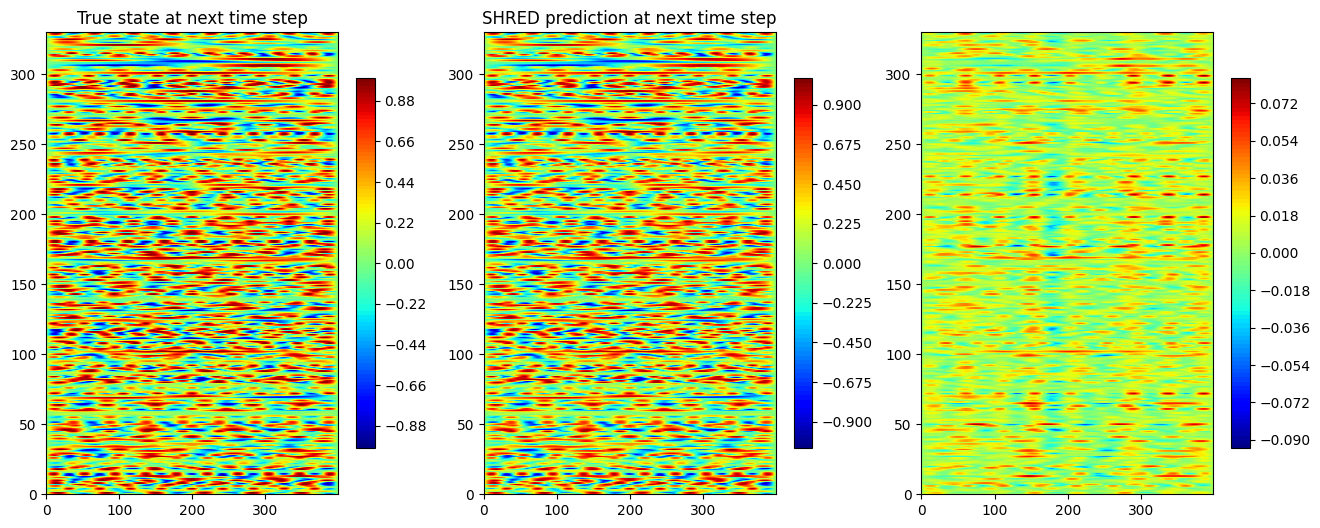

In [68]:
manager = DataManager(
    lags = 50,
    train_size= 0.8,
    val_size = 0.1,
    test_size = 0.1    
)

engine = SHREDEngine(manager, shred)

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.model._seq_model_outputs(test_dataset.X, sindy=False)
# print(test_dataset.X)
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.model.decoder(test_latent_from_sensors)

fig, ax = plt.subplots(1,3,figsize = (16,6))
cf1 = ax[0].contourf(test_dataset.Y.cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf1, ax=ax[0],shrink=0.8)
ax[0].set_title('True state at next time step')
cf2 = ax[1].contourf(test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf2, ax=ax[1],shrink=0.8)
ax[1].set_title('SHRED prediction at next time step')
cf3 = ax[2].contourf(test_dataset.Y.cpu().numpy()-test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf3, ax=ax[2],shrink=0.8)
# test_latent_from_sensors = engine.sensor_to_latent(test_dataset.X)

In [84]:
def u_sol(t,x,n,Kn = 1,l = 1,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)
l = 1
c = 1
T = 4
N_t = 200
N_X = 400
lags = 16
t= np.linspace(0,T,N_t)
x = np.linspace(0,l,N_X)
def data_generate(n,t,x,l=1,c=1):
    data = np.zeros((len(t),len(x)))
    for i in range(len(t)):
        data[i,:] = u_sol(t[i],x,n =1,Kn = 1, c=1)+u_sol(t[i],x,n =2,Kn = 1, c=1)
    return data

extra_test = [data_generate(n=4,t=t,x=x)]
X_data, full_states = trajectory_gen(extra_test,lags,sensors)
data_save1 = {
    'X':X_data,
    'y':full_states    
}

np.save('Wave_data/data_1_test.npy',data_save1)

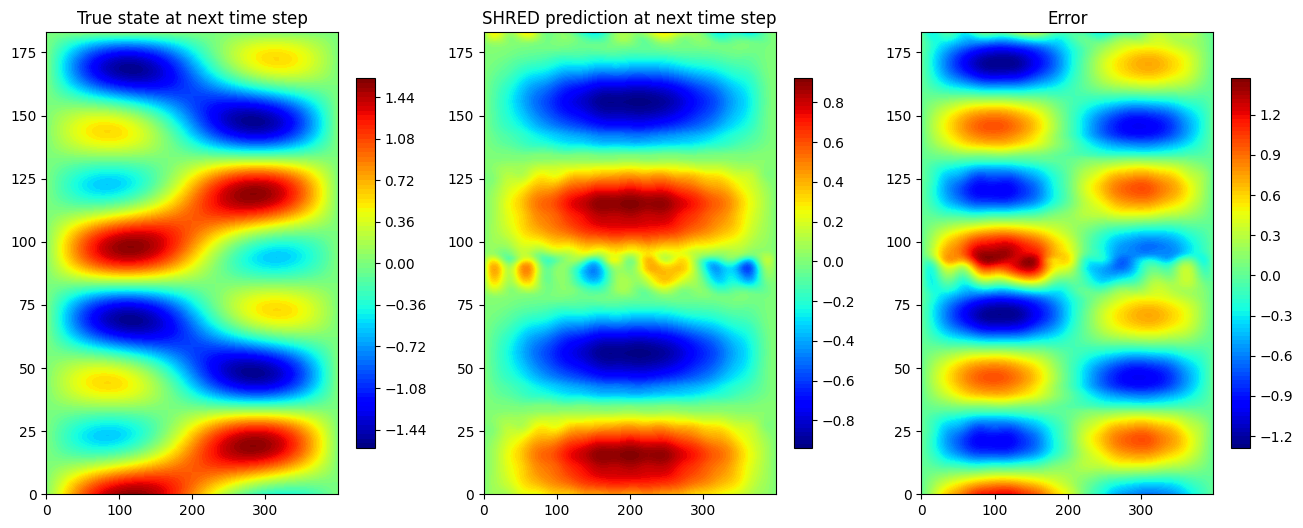

In [85]:
data_verify = np.load('Wave_data/data_1_test.npy',allow_pickle=True).item()

data_verify['X'] = torch.tensor(data_verify['X'],dtype = torch.float32,device = device)
data_verify['y'] = torch.tensor(data_verify['y'],dtype = torch.float32,device = device)

test_latent_from_sensors = engine.model._seq_model_outputs(data_verify['X'], sindy=False)

test_reconstruction = engine.model.decoder(test_latent_from_sensors)

fig, ax = plt.subplots(1,3,figsize = (16,6))
cf1 = ax[0].contourf(data_verify['y'].cpu().numpy(), 100,cmap = 'jet')
plt.colorbar(cf1, ax=ax[0],shrink=0.8) 
ax[0].set_title('True state at next time step')
cf2 = ax[1].contourf(test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf2, ax=ax[1],shrink=0.8)
ax[1].set_title('SHRED prediction at next time step')
cf3 = ax[2].contourf(data_verify['y'].cpu().numpy()-test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf3, ax=ax[2],shrink=0.8)                      
ax[2].set_title('Error')
plt.show()

